In [3]:
from datasets import Dataset, load_dataset
from qdrant_client import models, QdrantClient
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import Qdrant
import time
from datetime import timedelta
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
from dotenv import load_dotenv
import numpy as np

import sys
import os
sys.path.append(os.path.abspath('../'))

from model.llm import LLM
from pandas import read_parquet

In [2]:
llm = LLM(size=7, quantized=False, model_path="llmware/dragon-llama-7b-v0", adapter=False,)

Using device: cuda


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
llm.to_tokens_and_logprobs(["<human>: Hello, my name is John Doe. I am a software engineer and I work at Google.\nWhat is his name?\n<bot>:"], ["John Doe"])

([[('John', 0.9886432127636218),
   ('Do', 0.9948614409323047),
   ('e', 0.9999362271009362)]],
 [0.9835002865533226])

In [4]:
n = 10
itrf_dataset_buffer = []
k=10
options_enabled = False

# Overview of the dataset attributes
- Test

In [6]:
col_name = "retriever"

#tokenizer = LlamaTokenizer.from_pretrained("../models/llama7b", device_map='cuda')
embedding = HuggingFaceBgeEmbeddings(model_name="../models/retriever/bge-base-en-v1.5", model_kwargs={"device": "cuda:1"})

# Create the retriever
client = QdrantClient(url="http://localhost:6333")
db = Qdrant(client, 
            collection_name=col_name,
            embeddings=embedding,
            )

seed = 4048


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x)
    return e_x / e_x.sum()

def search(query: str, k: int = 3):
    success = False
    while not success:
        try:
            results = db.similarity_search_with_score(query, k=k)
            if results:
                success = True 
        except:
            print(f"Error with example {query}, retrying in 0.2s")
            time.sleep(0.2)
    return results

# This function creates an example with the query and the prediction and the top k results
def make_example(query: str, ground_truth:str, dataset_name:str, context = None, example_id = None, k: int = 3, split = "llm", retrieval = True, task="", domain=""):
    contexts = []
    if retrieval:
        # Search for the query
        results = search(query, k=k)

        # Get the softmax of the scores
        retriever_softmax = softmax([result[1] for result in results])
        context_texts = [llm.format_prompt(query, result[0].page_content) for result in results]
        llm_scores = llm.to_tokens_and_logprobs(context_texts, [ground_truth] * k)[1]
        llm_softmax = softmax(llm_scores)

        # Get the text of the results
        contexts = [{
            "text": result[0].page_content, 
            "src": result[0].metadata["src"] if "src" in result[0].metadata.keys() else "unknown", 
            "id": result[0].metadata["id"] if "id" in result[0].metadata.keys() else result[0].metadata["title"],
            "retriever_score": result[1],
            "llm_score": lscore,
            "retriever_softmax": rsoft, 
            "llm_softmax": lsoft, 
            "llm_weighted_softmax": rsoft * lsoft, 
            "original_context": False } 
            for result, rsoft, lsoft, lscore in zip(results, retriever_softmax, llm_softmax, llm_scores)]
    
    # Add the original context
    if context:
        contexts.append({
            "text": context, 
            "src": dataset_name, 
            "id": str(example_id), 
            "original_context": True
            })

    return { 
        "split": split, 
        "query": query, 
        "ground_truth": ground_truth, 
        "contexts": contexts,
        "src": dataset_name, 
        "id": str(example_id),
        "task": task,
        "domain": domain, 
        }

itrf_dataset_buffer = []
itrf = DataFrame(columns=["split", "query", "prediction", "context", "src", "id", "context_src", "context_id", "original_context", "task", "domain"])

def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True, task="", domain=""):
    examples = []
    ex = make_example(query, prediction, dataset_name, context, example_id, k, retrieval=retrieval, task=task, domain=domain)
    for c in ex["contexts"]:
        examples.append({ 
            "split": ex["split"], 
            "query": ex["query"], 
            "ground_truth": ex["ground_truth"], 

            "retriever_score": c["retriever_score"],
            "llm_score": c["llm_score"],
            "retriever_softmax": c["retriever_softmax"], 
            "llm_softmax": c["llm_softmax"], 
            "llm_weighted_softmax": c["llm_weighted_softmax"], 

            "context": c["text"], 
            "src": ex["src"], 
            "id": str(ex["id"]), 
            "context_src": c["src"], 
            "context_id": str(c["id"]), 
            "original_context": c["original_context"],
            "task": task,
            "domain": domain,
            })
    return examples

def save_example(i, start, last_time, example, dname, force=False):
    save_examples(i, start, last_time, [example], dname, force=force)

def save_examples(i, start, last_time, examples, dname, force=False):
    global itrf_dataset_buffer
    global itrf
    # Save the dataset to a file
    itrf_dataset_buffer.extend(examples)
    
    if i % 100 == 0 or force:
        current_time = time.time()
        print(f"Processed {i} {dname} examples, time: {str(timedelta(seconds=(last_time - start)))}, last 100 in {str(timedelta(seconds=(current_time - last_time)))}")
        last_time = current_time
        if len(itrf_dataset_buffer) > 0:
            if itrf.empty:
                itrf = DataFrame(itrf_dataset_buffer)
            else:
                df = DataFrame(itrf_dataset_buffer)
                itrf = pd.concat([itrf, df])
            itrf_dataset_buffer.clear()
        itrf.to_parquet("../data/dataset/itrf_dataset_reranker1.parquet")
        itrf.to_csv("../data/dataset/itrf_dataset_reranker1.csv")

# Building the dataset

## Open domain questioning

In [7]:
datasets_openqa = ["tau/commonsense_qa", "math_qa", "web_questions", "wiki_qa", "yahoo_answers_qa", "freebase_qa", "ms_marco"]

#### tau/commonsense_qa

In [ ]:
# def make_examples(query: str, prediction:str, dataset_name:str, context = None, example_id = None, k: int = 3, retrieval = True)
dname = datasets_openqa[0]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=seed))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    options = ""
    if options_enabled:
        options = "\n Options: "
    answer = -1
    for idx, o in enumerate(example["choices"]["label"]):
        if options_enabled:
            options += f"{o}: {example['choices']['text'][idx]}, "
        if example["answerKey"] == o:
            answer = idx
    if options_enabled: 
        options += "\n"

    query = example["question"] + options
    if options_enabled:
        prediction = f"{example['answerKey']}) {example['choices']['text'][answer]}"
    else:
        prediction =  f"{example['choices']['text'][answer]}"
    example_id = example["id"] + "_" + example["question_concept"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="mc", domain="openqa")
    
    save_examples(i, start, last_time, examples, dname)

itrf_dataset_buffer

In [9]:
len(itrf_dataset_buffer)

90

#### FreebaseQA

In [26]:
dname = datasets_openqa[5]
dataset = load_dataset(dname, split="train")

dataset[234]["Question-ID"]

'FreebaseQA-train-234'

In [ ]:
dname = datasets_openqa[5]
dataset = load_dataset(dname, split="train")
shuffled = iter(dataset.shuffle(seed=2024))
start = time.time()
last_time = start
for i in range(n):
    example = next(shuffled)

    query = example["RawQuestion"]
    prediction =  example['Parses']["Answers"][0]["AnswersName"][0][0]
    example_id = example["Question-ID"]
    examples = make_examples(query, prediction, dname, example_id=example_id, k=k, retrieval=True, task="qa", domain="openqa")
    
    save_examples(i, start, last_time, examples, dname)

itrf_dataset_buffer

#### MS Marco

In [9]:
dname = datasets_openqa[6]
dataset = load_dataset(dname, 'v2.1', split="train")
shuffled = iter(dataset.shuffle(seed=4048))
start = time.time()
empty_samples = []
last_time = start
for i in range(3500):
    example = next(shuffled)

    query = example["query"]
    example_id = dname + example["query_type"] + str(example["query_id"])

    if 1 in example["passages"]["is_selected"]:
        prediction =  example['answers'][0]
        context_id = example["passages"]["is_selected"].index(1)
        context = example["passages"]["passage_text"][context_id]
    else:
        prediction = "I don't know."
        context = example["passages"]["passage_text"][0]

    # examples = make_examples(query, prediction, dname, example_id=example_id, context=context, k=k, retrieval=True, task="qa", domain="openqa")
    
    # save_examples(i, start, last_time, examples, dname)

itrf_dataset_buffer

[]

# Analysis

In [2]:
from pandas import DataFrame, read_parquet
import pandas as pd

itrf = read_parquet("../data/dataset/itrf_dataset_reranker.parquet")
itrf["split"] = "reranker"

itrf

,split,query,ground_truth,retriever_score,llm_score,retriever_softmax,llm_softmax,llm_weighted_softmax,context,src,id,context_src,context_id,original_context,task,domain
0,reranker,Where do you put junk mail?,trash,0.736790,0.000016,0.101507,0.099738,0.010124,11. Leave a woven or canvas hamper on the floo...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,11978156,False,mc,openqa
1,reranker,Where do you put junk mail?,trash,0.731681,0.000050,0.100989,0.099742,0.010073,Have one basket for each family member and dro...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,11821405,False,mc,openqa
2,reranker,Where do you put junk mail?,trash,0.729482,0.000002,0.100768,0.099737,0.010050,Your mail needs to have a designated spot. Whe...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,10073037,False,mc,openqa
3,reranker,Where do you put junk mail?,trash,0.725174,0.000660,0.100334,0.099803,0.010014,Does your email inbox get filled with junk mai...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,10078181,False,mc,openqa
4,reranker,Where do you put junk mail?,trash,0.720310,0.000044,0.099848,0.099741,0.009959,Offering everything from shelves for sale to s...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,14221319,False,mc,openqa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,reranker,Rose's mom took Rose roller skating one night....,Rose's mom's seat,0.619681,0.007413,0.099814,0.100390,0.010020,mom. She decided she had to save Preston’s mom...,quarel,QuaRel_V1_B5_1357,oscar,15093224,False,mc,rc
996,reranker,Rose's mom took Rose roller skating one night....,Rose's mom's seat,0.619334,0.015004,0.099779,0.101155,0.010093,"Maddie: No, I didn't want to stay in the car. ...",quarel,QuaRel_V1_B5_1357,oscar,4668422,False,mc,rc
997,reranker,Rose's mom took Rose roller skating one night....,Rose's mom's seat,0.619140,0.003372,0.099760,0.099985,0.009974,"my mother is at the very center , you're tired...",quarel,QuaRel_V1_B5_1357,oscar,9136366,False,mc,rc
998,reranker,Rose's mom took Rose roller skating one night....,Rose's mom's seat,0.617969,0.000511,0.099643,0.099699,0.009934,"Yes, my mom is a skater and that’s how I start...",quarel,QuaRel_V1_B5_1357,oscar,4057174,False,mc,rc


In [3]:

total = len(itrf)
unanswerable = len(itrf[itrf["ground_truth"] == "I don't know."])
llm_clueless = len(itrf[itrf["llm_score"] < 0.001])
# If the llm softmax score is between 0.09 and 0.11 so equally distributed
llm_indecisive = len(itrf[(itrf["llm_softmax"] > 0.098) & (itrf["llm_softmax"] < 0.102)])

print(f"Total: {total}, Unanswerable: {unanswerable}, LLM clueless: {llm_clueless}, LLM undecisive: {llm_indecisive}")
# Print the percentage/relative values
print(f"Unanswerable: {unanswerable/total}, LLM clueless: {llm_clueless/total}, LLM indecisive: {llm_indecisive/total}")

Total: 299010, Unanswerable: 13150, LLM clueless: 253722, LLM undecisive: 253953
Unanswerable: 0.043978462258787335, LLM clueless: 0.8485401826025886, LLM indecisive: 0.8493127320156516


In [8]:
len(itrf[(itrf["llm_softmax"] < 0.080)])/total

0.025280090966857297

In [9]:
len(itrf[itrf["llm_softmax"] > 0.3])

0

In [10]:
itrf["retriever_softmax"].mean()

0.1

In [13]:
retriever_indecisive = len(itrf[(itrf["retriever_softmax"] > 0.098) & (itrf["retriever_softmax"] < 0.102)])
retriever_indecisive/total

0.8395070398983312

In [7]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    #e_x = np.exp(x)
    return x / x.sum()

In [15]:
softmax(itrf[itrf["query"] == "Where do you put junk mail?"]["llm_score"])

0    0.000620
1    0.001890
2    0.000086
3    0.025153
4    0.001663
5    0.000073
6    0.004509
7    0.011405
8    0.383681
9    0.570921
Name: llm_score, dtype: float64

In [16]:
itrf[itrf.duplicated(keep='first')][itrf[itrf.duplicated(keep='first')].duplicated()]

,split,query,ground_truth,retriever_score,llm_score,retriever_softmax,llm_softmax,llm_weighted_softmax,context,src,id,context_src,context_id,original_context,task,domain
949,reranker,If you're on the terrace enjoying warm Mediter...,southern europe,0.665399,2.499620e-07,0.098900,0.099591,0.009850,See Mediterranean,tau/commonsense_qa,5f9284000bab614c231201948764d57d_terrace,wiki,List of Baedeker Guides,False,mc,openqa
122,reranker,"The attack took the player by surprise, he say...",surrender,0.740149,1.764890e-02,0.102511,0.056090,0.005750,"the player's actions, the game ends with diffe...",tau/commonsense_qa,a425a788c5d2ac50816e5110b7d09911_attack,oscar,14910653,False,mc,openqa
719,reranker,"find the compound ratio of ( 1 : 2 ) , ( 2 : 3...",1 : 4,0.704780,7.511952e-08,0.098906,0.100000,0.009891,ratios:,math_qa,other_1072,oscar,1916951,False,mc,openqa
496,reranker,3 candidates in an election and received 3000 ...,71.42 %,0.736847,5.633781e-15,0.099899,0.100000,0.009990,Each elector voted for up to three candidates....,math_qa,gain_3150,wiki,Results of the 1903 Australian federal electio...,False,mc,openqa
497,reranker,3 candidates in an election and received 3000 ...,71.42 %,0.736847,5.633781e-15,0.099899,0.100000,0.009990,Each elector voted for up to three candidates....,math_qa,gain_3150,wiki,Results of the 1903 Australian federal electio...,False,mc,openqa
697,reranker,an alloy weighing 20 ounces is 70 percent gold...,9,0.754721,9.916255e-04,0.099532,0.100040,0.009957,other metals to add strength. The most popular...,math_qa,gain_3370,oscar,4848513,False,mc,openqa
698,reranker,an alloy weighing 20 ounces is 70 percent gold...,9,0.754721,9.916255e-04,0.099532,0.100040,0.009957,other metals to add strength. The most popular...,math_qa,gain_3370,oscar,4848513,False,mc,openqa
699,reranker,an alloy weighing 20 ounces is 70 percent gold...,9,0.754721,9.916255e-04,0.099532,0.100040,0.009957,other metals to add strength. The most popular...,math_qa,gain_3370,oscar,4848513,False,mc,openqa
166,reranker,where is the pepsi center?,Denver,0.741884,2.657073e-06,0.098590,0.091105,0.008982,"at Pepsi Center, Denver, Colorado Scoring Summ...",web_questions,http://www.freebase.com/view/en/pepsi_center_D...,wiki,2007 Colorado Crush season,False,qa,openqa
167,reranker,where is the pepsi center?,Denver,0.741884,2.657073e-06,0.098590,0.091105,0.008982,"at Pepsi Center, Denver, Colorado Scoring Summ...",web_questions,http://www.freebase.com/view/en/pepsi_center_D...,wiki,2007 Colorado Crush season,False,qa,openqa


In [17]:
# itrf.drop_duplicates()
itrf.drop_duplicates(inplace=True)
len(itrf)

298918

In [18]:
itrf["id"].value_counts()[itrf["id"].value_counts() > 10]

id
Q283_Mandibular first molar                                              100
http://www.freebase.com/view/en/dominican_republic_Dominican peso         90
Q30_Deepwater drilling                                                    90
Q125_Franklin D. Roosevelt                                                90
Q914_Schizophrenia                                                        90
                                                                        ... 
http://www.freebase.com/view/en/basque_language_Spain                     20
Q2405_Modesto, California                                                 20
http://www.freebase.com/view/en/south_africa_Lesotho                      19
http://www.freebase.com/view/en/china_Single-party state                  19
http://www.freebase.com/view/en/peter_parker_spider_man_Marvel Comics     19
Name: count, Length: 1323, dtype: int64

In [19]:
import hashlib
itrf["id_new"] = (itrf["id"] + "_" + itrf["query"] + "_" + itrf['ground_truth']).apply(lambda x: hashlib.md5(x.encode()).hexdigest())

#len(itrf[.value_counts() > 10])

In [20]:
itrf["id_new"]
len(itrf["id_new"].value_counts()[itrf["id_new"].value_counts() < 10])

68

In [81]:
idx = 0
for samples in itrf:
    idx = 1 + idx
    if idx % 100 == 0:
        print(idx)

In [41]:
index = range(len(itrf))
itrf.index = index

In [42]:
itrf

,split,query,ground_truth,retriever_score,llm_score,retriever_softmax,llm_softmax,llm_weighted_softmax,context,src,id,context_src,context_id,original_context,task,domain,id_new
0,reranker,Where do you put junk mail?,trash,0.736790,0.000016,0.101507,0.099738,0.010124,11. Leave a woven or canvas hamper on the floo...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,11978156,False,mc,openqa,68a89296813f546183d8c2d3c528a89a
1,reranker,Where do you put junk mail?,trash,0.731681,0.000050,0.100989,0.099742,0.010073,Have one basket for each family member and dro...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,11821405,False,mc,openqa,68a89296813f546183d8c2d3c528a89a
2,reranker,Where do you put junk mail?,trash,0.729482,0.000002,0.100768,0.099737,0.010050,Your mail needs to have a designated spot. Whe...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,10073037,False,mc,openqa,68a89296813f546183d8c2d3c528a89a
3,reranker,Where do you put junk mail?,trash,0.725174,0.000660,0.100334,0.099803,0.010014,Does your email inbox get filled with junk mai...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,10078181,False,mc,openqa,68a89296813f546183d8c2d3c528a89a
4,reranker,Where do you put junk mail?,trash,0.720310,0.000044,0.099848,0.099741,0.009959,Offering everything from shelves for sale to s...,tau/commonsense_qa,0fd12ff0fd9c43454251e6213ab7bf22_junk mail,oscar,14221319,False,mc,openqa,68a89296813f546183d8c2d3c528a89a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298913,reranker,Rose's mom took Rose roller skating one night....,Rose's mom's seat,0.619681,0.007413,0.099814,0.100390,0.010020,mom. She decided she had to save Preston’s mom...,quarel,QuaRel_V1_B5_1357,oscar,15093224,False,mc,rc,71d8aa619375ad4edb14779b4aaec11b
298914,reranker,Rose's mom took Rose roller skating one night....,Rose's mom's seat,0.619334,0.015004,0.099779,0.101155,0.010093,"Maddie: No, I didn't want to stay in the car. ...",quarel,QuaRel_V1_B5_1357,oscar,4668422,False,mc,rc,71d8aa619375ad4edb14779b4aaec11b
298915,reranker,Rose's mom took Rose roller skating one night....,Rose's mom's seat,0.619140,0.003372,0.099760,0.099985,0.009974,"my mother is at the very center , you're tired...",quarel,QuaRel_V1_B5_1357,oscar,9136366,False,mc,rc,71d8aa619375ad4edb14779b4aaec11b
298916,reranker,Rose's mom took Rose roller skating one night....,Rose's mom's seat,0.617969,0.000511,0.099643,0.099699,0.009934,"Yes, my mom is a skater and that’s how I start...",quarel,QuaRel_V1_B5_1357,oscar,4057174,False,mc,rc,71d8aa619375ad4edb14779b4aaec11b


In [46]:
# Recalculate the softmax
import time
sameid = itrf[itrf["id_new"] == ""]
new_id = ""
llm_scores = -1
retriever_scores = -1
total = 0

start = time.time()

for row in itrf.itertuples():
    # print(row)
    # break
    if sameid.empty or (not row.id_new == new_id):
        sameid = itrf[itrf["id_new"] == row.id_new]
        new_id = row.id_new
        llm_scores = sameid["llm_score"].sum()
        retriever_scores = sameid["retriever_score"].sum()
    llm_sm = row.llm_score / llm_scores
    retriever_sm = row.retriever_score / retriever_scores
    itrf.at[row.Index, "llm_softmax"] = llm_sm
    itrf.at[row.Index, "retriever_softmax"] = retriever_sm
    itrf.at[row.Index, "llm_weighted_softmax"] = retriever_sm * llm_sm

    total += 1
    if total % 1000 == 0:
        # Formatted datetime
        print(f"Processed {total} in {str(timedelta(seconds=(time.time() - start)))}")

Processed 1000 in 0:00:01.315919
Processed 2000 in 0:00:02.624620
Processed 3000 in 0:00:03.954023
Processed 4000 in 0:00:05.269257
Processed 5000 in 0:00:06.605874
Processed 6000 in 0:00:07.948452
Processed 7000 in 0:00:09.274866
Processed 8000 in 0:00:10.616930
Processed 9000 in 0:00:11.949457
Processed 10000 in 0:00:13.288460
Processed 11000 in 0:00:14.630937
Processed 12000 in 0:00:15.954959
Processed 13000 in 0:00:17.303059
Processed 14000 in 0:00:18.622059
Processed 15000 in 0:00:19.955800
Processed 16000 in 0:00:21.289469
Processed 17000 in 0:00:22.625361
Processed 18000 in 0:00:23.986375
Processed 19000 in 0:00:25.329891
Processed 20000 in 0:00:26.651667
Processed 21000 in 0:00:27.996866
Processed 22000 in 0:00:29.358430
Processed 23000 in 0:00:30.694107
Processed 24000 in 0:00:32.040263
Processed 25000 in 0:00:33.386099
Processed 26000 in 0:00:34.712387
Processed 27000 in 0:00:36.051988
Processed 28000 in 0:00:37.368500
Processed 29000 in 0:00:38.723736
Processed 30000 in 0:00

/tmp/ipykernel_1073169/723198104.py:19: RuntimeWarning: invalid value encountered in scalar divide
  llm_sm = row.llm_score / llm_scores


Processed 144000 in 0:03:11.864860
Processed 145000 in 0:03:13.194950
Processed 146000 in 0:03:14.540189
Processed 147000 in 0:03:15.919958
Processed 148000 in 0:03:17.238565
Processed 149000 in 0:03:18.555487
Processed 150000 in 0:03:19.886454
Processed 151000 in 0:03:21.204637
Processed 152000 in 0:03:22.526328
Processed 153000 in 0:03:23.914063
Processed 154000 in 0:03:25.319066
Processed 155000 in 0:03:26.729421
Processed 156000 in 0:03:28.132237
Processed 157000 in 0:03:29.551580
Processed 158000 in 0:03:30.902218
Processed 159000 in 0:03:32.223919
Processed 160000 in 0:03:33.537914
Processed 161000 in 0:03:34.858662
Processed 162000 in 0:03:36.167275
Processed 163000 in 0:03:37.484089
Processed 164000 in 0:03:38.826967
Processed 165000 in 0:03:40.156480
Processed 166000 in 0:03:41.487948
Processed 167000 in 0:03:42.824490
Processed 168000 in 0:03:44.136273
Processed 169000 in 0:03:45.480179
Processed 170000 in 0:03:46.791023
Processed 171000 in 0:03:48.117598
Processed 172000 in 

In [49]:
itrf.to_parquet("../data/dataset/itrf_dataset_reranker_processed.parquet")

In [8]:
for x,y, c in zip(softmax(itrf[itrf["query"] == "Where do you put junk mail?"]["retriever_score"]), itrf[itrf["query"] == "Where do you put junk mail?"]["retriever_softmax"],  itrf[itrf["query"] == "Where do you put junk mail?"]["context"]):
    print(f"{x:.2%}, {y:.2%} Are the same:", x == y, c)

10.21%, 10.21% Are the same: True 11. Leave a woven or canvas hamper on the floor by the door in the entryway so you can toss junk mail as soon as it arrives, offers Stephanie Goldberg Glazer of yourpersonalmanager.com. And follow tips numbers 18 to 21 to stop junk mail at the source.
10.14%, 10.14% Are the same: True Have one basket for each family member and drop the junk mail into the wastebasket you've placed just below the row of baskets on your wall. This way everyone has easy access to his or her mail and junk mail is handled as well. 2) Kitchen organizer. There are many jobs in the kitchen that baskets pull off beautifully. One such job is that of napkin holder.
10.11%, 10.11% Are the same: True Your mail needs to have a designated spot. When you pick it up from the mailbox each day, bring it into the house and put it in the same spot. This can be a basket, a designated space on the kitchen counter, or on your desk in your home office.
10.05%, 10.05% Are the same: True Does you

In [9]:
itrf[itrf["query"] == "Where do you put junk mail?"]["llm_softmax"].sum()

1.0

Test for average token, context length and type of answer

In [3]:
itrf = read_parquet("../data/dataset/itrf_dataset_reranker_processed.parquet")
len(itrf)

285720

In [10]:
print(len(itrf[itrf["ground_truth"] == "I don't know."]))
itrf = itrf[itrf["ground_truth"] != "I don't know."]
len(itrf)

0


285780

(array([8173., 6875., 4301., 2970., 2191., 1633., 1532., 1596., 1637.,
        1750., 1745., 1838., 1809., 1988., 1942., 2064., 2000., 2254.,
        2524., 2535., 2547., 2853., 3127., 3103., 1718., 3972., 4529.,
        4607., 4918., 4941., 5091., 5128., 5581., 5794., 5818., 6101.,
        6355., 6342., 6810., 6928., 7336., 7155., 7210., 6908., 7160.,
        6606., 6687., 6384., 6455., 5779.]),
 array([ 1.  ,  2.96,  4.92,  6.88,  8.84, 10.8 , 12.76, 14.72, 16.68,
        18.64, 20.6 , 22.56, 24.52, 26.48, 28.44, 30.4 , 32.36, 34.32,
        36.28, 38.24, 40.2 , 42.16, 44.12, 46.08, 48.04, 50.  , 51.96,
        53.92, 55.88, 57.84, 59.8 , 61.76, 63.72, 65.68, 67.64, 69.6 ,
        71.56, 73.52, 75.48, 77.44, 79.4 , 81.36, 83.32, 85.28, 87.24,
        89.2 , 91.16, 93.12, 95.08, 97.04, 99.  ]),
 <BarContainer object of 50 artists>)

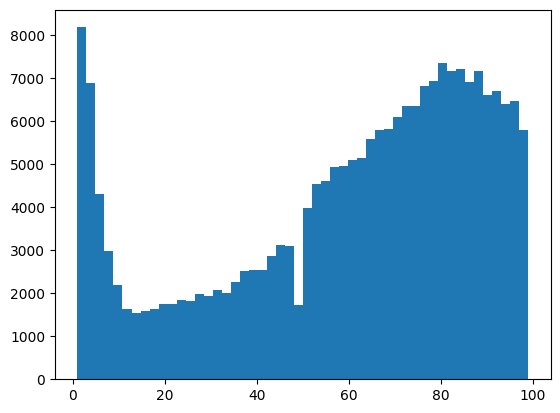

In [11]:
context_length = itrf["context"].apply(lambda x: len(x.split(" ")))
npa = context_length.to_numpy()
npa = npa[npa < 100]
plt.hist(npa, bins=50)

In [12]:
print(len(itrf), len(itrf[itrf.isnull().sum(axis=1) > 0]))
itrf[itrf.isnull().sum(axis=1) > 0]

285780 60


,split,query,ground_truth,retriever_score,llm_score,retriever_softmax,llm_softmax,llm_weighted_softmax,context,src,id,context_src,context_id,original_context,task,domain,id_new
143056,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.762540,0.0,0.101544,NaN,NaN,"Strangely, it is not an area that most employe...",yahoo_answers_qa,1760733_Society & Culture,oscar,5952059,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143057,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.762082,0.0,0.101483,NaN,NaN,"You know what question was not asked, and is s...",yahoo_answers_qa,1760733_Society & Culture,oscar,9546244,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143058,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.758066,0.0,0.100948,NaN,NaN,As the national conversation about sexual hara...,yahoo_answers_qa,1760733_Society & Culture,oscar,11035109,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143059,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.753641,0.0,0.100359,NaN,NaN,Here are three simple questions you can apply ...,yahoo_answers_qa,1760733_Society & Culture,oscar,7018790,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143060,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.751065,0.0,0.100016,NaN,NaN,If someone you know asks about your sexual act...,yahoo_answers_qa,1760733_Society & Culture,oscar,4135559,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143061,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.749437,0.0,0.099799,NaN,NaN,Those dealing with sexual harassment have a lo...,yahoo_answers_qa,1760733_Society & Culture,oscar,4174234,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143062,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.743997,0.0,0.099075,NaN,NaN,sexual harassment for \r\nindividuals who have...,yahoo_answers_qa,1760733_Society & Culture,oscar,5131003,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143063,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.743936,0.0,0.099067,NaN,NaN,One of the primary stakeholders of a sexual ha...,yahoo_answers_qa,1760733_Society & Culture,oscar,5952059,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143064,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.742955,0.0,0.098936,NaN,NaN,What is defined as sexual harassment at the wo...,yahoo_answers_qa,1760733_Society & Culture,oscar,3398544,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6
143065,reranker,Questions about sexual harassment?,"yeah it's totally messed up, i really don't kn...",0.741734,0.0,0.098773,NaN,NaN,It can involve demands for sex from a supervis...,yahoo_answers_qa,1760733_Society & Culture,oscar,5879740,False,qa,openqa,bfe3fc3721c44e998e8b2435ff38ada6


In [13]:
itrf.dropna(inplace=True)
len(itrf)

285720

In [14]:
mean = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) < 10]["llm_softmax"].mean()
rmean = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) > 10]["llm_softmax"].mean()
var = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) < 10]["llm_softmax"].var()
rvar = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) > 10]["llm_softmax"].var()

print("LLM Softmax")
print("Mean:", mean, "Variance:", var, "Mean of rest:", rmean, "Variance of rest:", rvar)

mean = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) < 10]["retriever_softmax"].mean()
var = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) < 10]["retriever_softmax"].var()

print("Retriever Softmax")
print("Mean:", mean, "Variance:", var)

mean = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) < 10]["llm_weighted_softmax"].mean()
var = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) < 10]["llm_weighted_softmax"].var()

print("LLM Weighted Softmax")
print("Mean:", mean, "Variance:", var)



LLM Softmax
Mean: 0.016741006019542565 Variance: 0.002602718666362845 Mean of rest: 0.10783877636931284 Variance of rest: 0.05643561946129208
Retriever Softmax
Mean: 0.10041453451240152 Variance: 8.261445164454323e-06
LLM Weighted Softmax
Mean: 0.001674716352236904 Variance: 2.588703782062893e-05


In [15]:
gmean = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) > 30]["llm_softmax"].mean()
gvar = itrf[itrf["context"].apply(lambda x: len(x.split(" "))) < 10]["llm_softmax"].var()

print("LLM Softmax")
print("Mean:", gmean, "Variance:", gvar)

LLM Softmax
Mean: 0.11456387305988136 Variance: 0.002602718666362845


In [16]:
corr = itrf["llm_softmax"].corr(itrf["context"].apply(lambda x: len(x.split(" "))))
corr

0.4168336168583819

In [17]:
rcorr = itrf["retriever_softmax"].corr(itrf["context"].apply(lambda x: len(x.split(" "))))
rcorr

-0.04123045701012996

In [18]:
# Is this significant
from scipy.stats import pearsonr

stat = pearsonr(itrf["llm_softmax"], itrf["context"].apply(lambda x: len(x.split(" "))))

print("Correlation:", stat[0], "p-value:", stat[1])

Correlation: 0.41683361685840764 p-value: 0.0


In [19]:
n = 30
length = itrf["context"].apply(lambda x: len(x.split(" ")))
length_over_n = length[length > n]
itrf_over_n = itrf[length > n]

stat = pearsonr(itrf_over_n["llm_softmax"], length_over_n)

print("Correlation:", stat[0], "p-value:", stat[1])

Correlation: 0.4540519223350882 p-value: 0.0


In [20]:
stat = pearsonr(itrf["llm_score"], itrf["context"].apply(lambda x: len(x.split(" "))))

print("Correlation:", stat[0], "p-value:", stat[1])

Correlation: 0.116211603034575 p-value: 0.0


In [21]:
stat = pearsonr(itrf["retriever_score"], itrf["context"].apply(lambda x: len(x.split(" "))))

print("Correlation:", stat[0], "p-value:", stat[1])

Correlation: 0.03567997547180651 p-value: 3.8521222861058765e-81


In [22]:
stat = pearsonr(itrf["llm_weighted_softmax"], itrf["context"].apply(lambda x: len(x.split(" "))))

print("Correlation:", stat[0], "p-value:", stat[1])

Correlation: 0.41707649885585557 p-value: 0.0


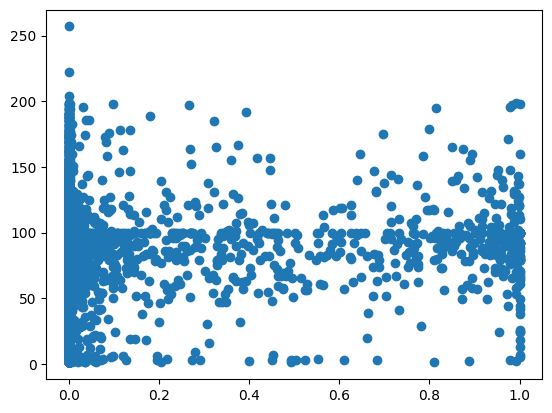

In [30]:
df = itrf.sample(10000)
plt.scatter(df["llm_score"], df["context"].apply(lambda x: len(x.split(" "))))

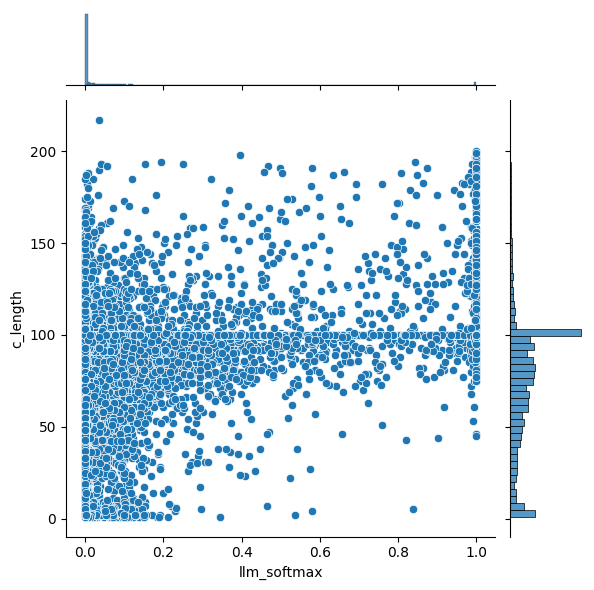

In [26]:
import seaborn as sns

df = itrf.sample(frac=0.05 )
df["c_length"] = df["context"].apply(lambda x: len(x.split(" ")))
sns.jointplot(x='llm_softmax', y='c_length', data=df)


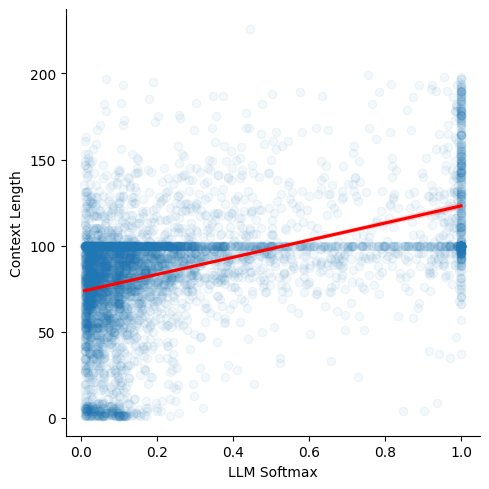

In [32]:
df = itrf.sample(frac=0.05)
df = df[df["llm_softmax"] > 0.01]
df["c_length"] = df["context"].apply(lambda x: len(x.split(" ")))

plot = sns.lmplot(x='llm_softmax', y='c_length', data=df, scatter_kws={'alpha':0.05}, line_kws={'color': 'red'})
plot.set_axis_labels("LLM Softmax", "Context Length")

(array([21022.,  6650.,  4983.,  6330.,  6091.,  8277., 10017., 11830.,
        16968., 16074., 21281., 23755., 21525., 23840., 18612., 44957.,
         5593.,  3659.,  3061.,  2149.,  1714.,  1523.,  1068.,   852.,
          665.,   732.,   688.,   565.,   607.,   611.]),
 array([  1. ,   7.6,  14.2,  20.8,  27.4,  34. ,  40.6,  47.2,  53.8,
         60.4,  67. ,  73.6,  80.2,  86.8,  93.4, 100. , 106.6, 113.2,
        119.8, 126.4, 133. , 139.6, 146.2, 152.8, 159.4, 166. , 172.6,
        179.2, 185.8, 192.4, 199. ]),
 <BarContainer object of 30 artists>)

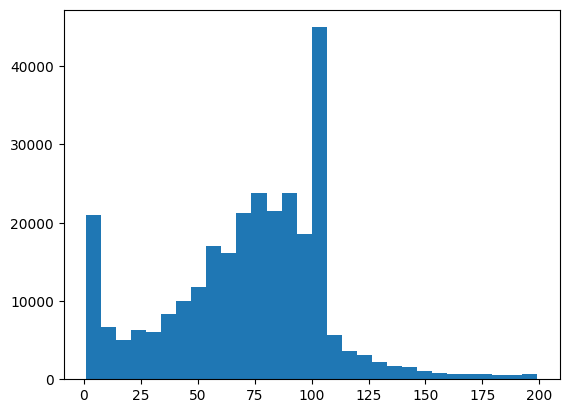

In [4]:
counts =itrf["context"].apply(lambda x: len(x.split(" "))).value_counts()
counts = counts[counts.index < 200]

plt.hist(counts.index, bins=30, weights=counts.values)

In [41]:
stat = pearsonr(itrf[itrf["context_src"] == "oscar"]["llm_score"], itrf[itrf["context_src"] == "oscar"]["context"].apply(lambda x: len(x.split(" "))))

print("Correlation:", stat[0], "p-value:", stat[1])

Correlation: 0.08423479252727661 p-value: 0.0


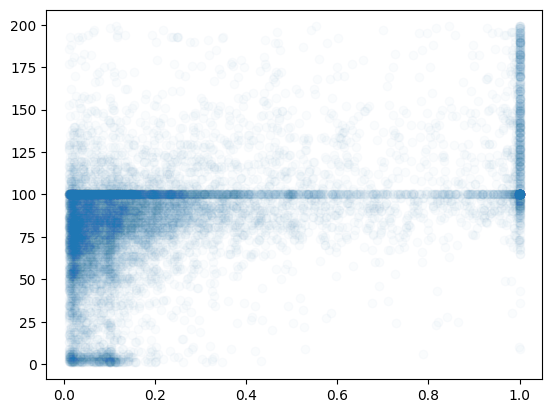

In [24]:
df = itrf.sample(frac=0.1)
df = df[df["llm_softmax"] > 0.01]
plt.scatter(df["llm_softmax"], df["context"].apply(lambda x: len(x.split(" "))),alpha=0.02) # bins=50, cmap='Blues')

## Deprecated

In [25]:
print(np.round(np.exp(np.log([0.0005, 0.0015, 0.0000015]))/(np.sum(np.exp(np.log([0.0005, 0.0015, 0.0000015])))), 2))

[0.25 0.75 0.  ]


In [10]:
len(empty_samples)

1315